In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import cv2
import os
import imutils
import matplotlib.pyplot as plt
from skimage import exposure, img_as_ubyte
from skimage.filters import threshold_otsu, sobel
from skimage.morphology import binary_closing, binary_opening, disk
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [7]:
# Define paths and parameters
train_path = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"
image_size = 256
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']


In [2]:
# Function to crop the image to focus on the brain region
def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular region out of them.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Threshold the image, then perform a series of erosions + dilations to remove noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in the thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, img_as_ubyte, filters, feature
from skimage.filters import gaussian, sobel, threshold_otsu
from skimage.util import img_as_float
def preprocess_image(image, image_size=256, show_stages=False):
    """
    Preprocesses a brain MRI image for tumor detection with Gamma + Gaussian Smoothing (σ=1) and visualization.
    Returns the preprocessed image as a NumPy array.
    """
    # Step 1: Crop the image to focus on the brain region
    cropped_image = crop_img(image)

    # Step 2: Resize the image
    resized_image = cv2.resize(cropped_image, (image_size, image_size), interpolation=cv2.INTER_CUBIC)

    # Step 3: Convert to grayscale
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2GRAY)

    # Step 4: Normalization (Scale to [0, 1])
    normalized_image = gray_image / 255.0

    # Step 5: Bias Field Correction (CLAHE for better contrast enhancement)
    equalized_image = exposure.equalize_adapthist(normalized_image, clip_limit=0.01)

    # Step 6: Noise Reduction (Non-Local Means Denoising)
    denoised_image = cv2.fastNlMeansDenoising(img_as_ubyte(equalized_image), None, h=7, templateWindowSize=5, searchWindowSize=15)

    # Step 7: Edge Enhancement (Unsharp Masking)
    blurred = cv2.GaussianBlur(denoised_image, (5, 5), 0)
    edge_enhanced = cv2.addWeighted(denoised_image, 1.5, blurred, -0.5, 0)

    # Step 8: Normalize the edge-enhanced image
    edge_enhanced_normalized = (edge_enhanced - edge_enhanced.min()) / (edge_enhanced.max() - edge_enhanced.min())

    # Step 9: Apply Gamma Correction (γ=0.5)
    gamma_corrected = exposure.adjust_gamma(edge_enhanced_normalized, gamma=1.5)

    # Step 10: Apply Gaussian Smoothing (σ=1) to Gamma Corrected Image
    gamma_gaussian_smoothed = gaussian(gamma_corrected, sigma=0.5)

    # Step 11: Display intermediate stages (optional)
    if show_stages:
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))
        axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')

        axes[0, 1].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        axes[0, 1].set_title('Cropped Image')
        axes[0, 1].axis('off')

        axes[0, 2].imshow(resized_image, cmap='gray')
        axes[0, 2].set_title('Resized Image')
        axes[0, 2].axis('off')

        axes[0, 3].imshow(gray_image, cmap='gray')
        axes[0, 3].set_title('Grayscale Image')
        axes[0, 3].axis('off')

        axes[1, 0].imshow(normalized_image, cmap='gray')
        axes[1, 0].set_title('Normalized Image')
        axes[1, 0].axis('off')

        axes[1, 1].imshow(equalized_image, cmap='gray')
        axes[1, 1].set_title('CLAHE Equalized')
        axes[1, 1].axis('off')

        axes[1, 2].imshow(denoised_image, cmap='gray')
        axes[1, 2].set_title('Denoised Image')
        axes[1, 2].axis('off')

        axes[1, 3].imshow(edge_enhanced_normalized, cmap='gray')
        axes[1, 3].set_title('Edge Enhanced + Normalized')
        axes[1, 3].axis('off')

        axes[2, 0].imshow(sobel(edge_enhanced_normalized), cmap='gray')
        axes[2, 0].set_title('Sobel Edge Detection')
        axes[2, 0].axis('off')

        axes[2, 1].imshow(feature.canny(edge_enhanced_normalized, sigma=1), cmap='gray')
        axes[2, 1].set_title('Canny Edge Detection')
        axes[2, 1].axis('off')

        axes[2, 2].imshow(edge_enhanced_normalized > threshold_otsu(edge_enhanced_normalized), cmap='gray')
        axes[2, 2].set_title("Otsu's Thresholding")
        axes[2, 2].axis('off')

        axes[2, 3].imshow(gamma_gaussian_smoothed, cmap='gray')
        axes[2, 3].set_title('Gamma + Gaussian Smoothing (σ=1)')
        axes[2, 3].axis('off')

        plt.tight_layout()
        plt.show()

    # Return only the preprocessed image
    return gamma_gaussian_smoothed



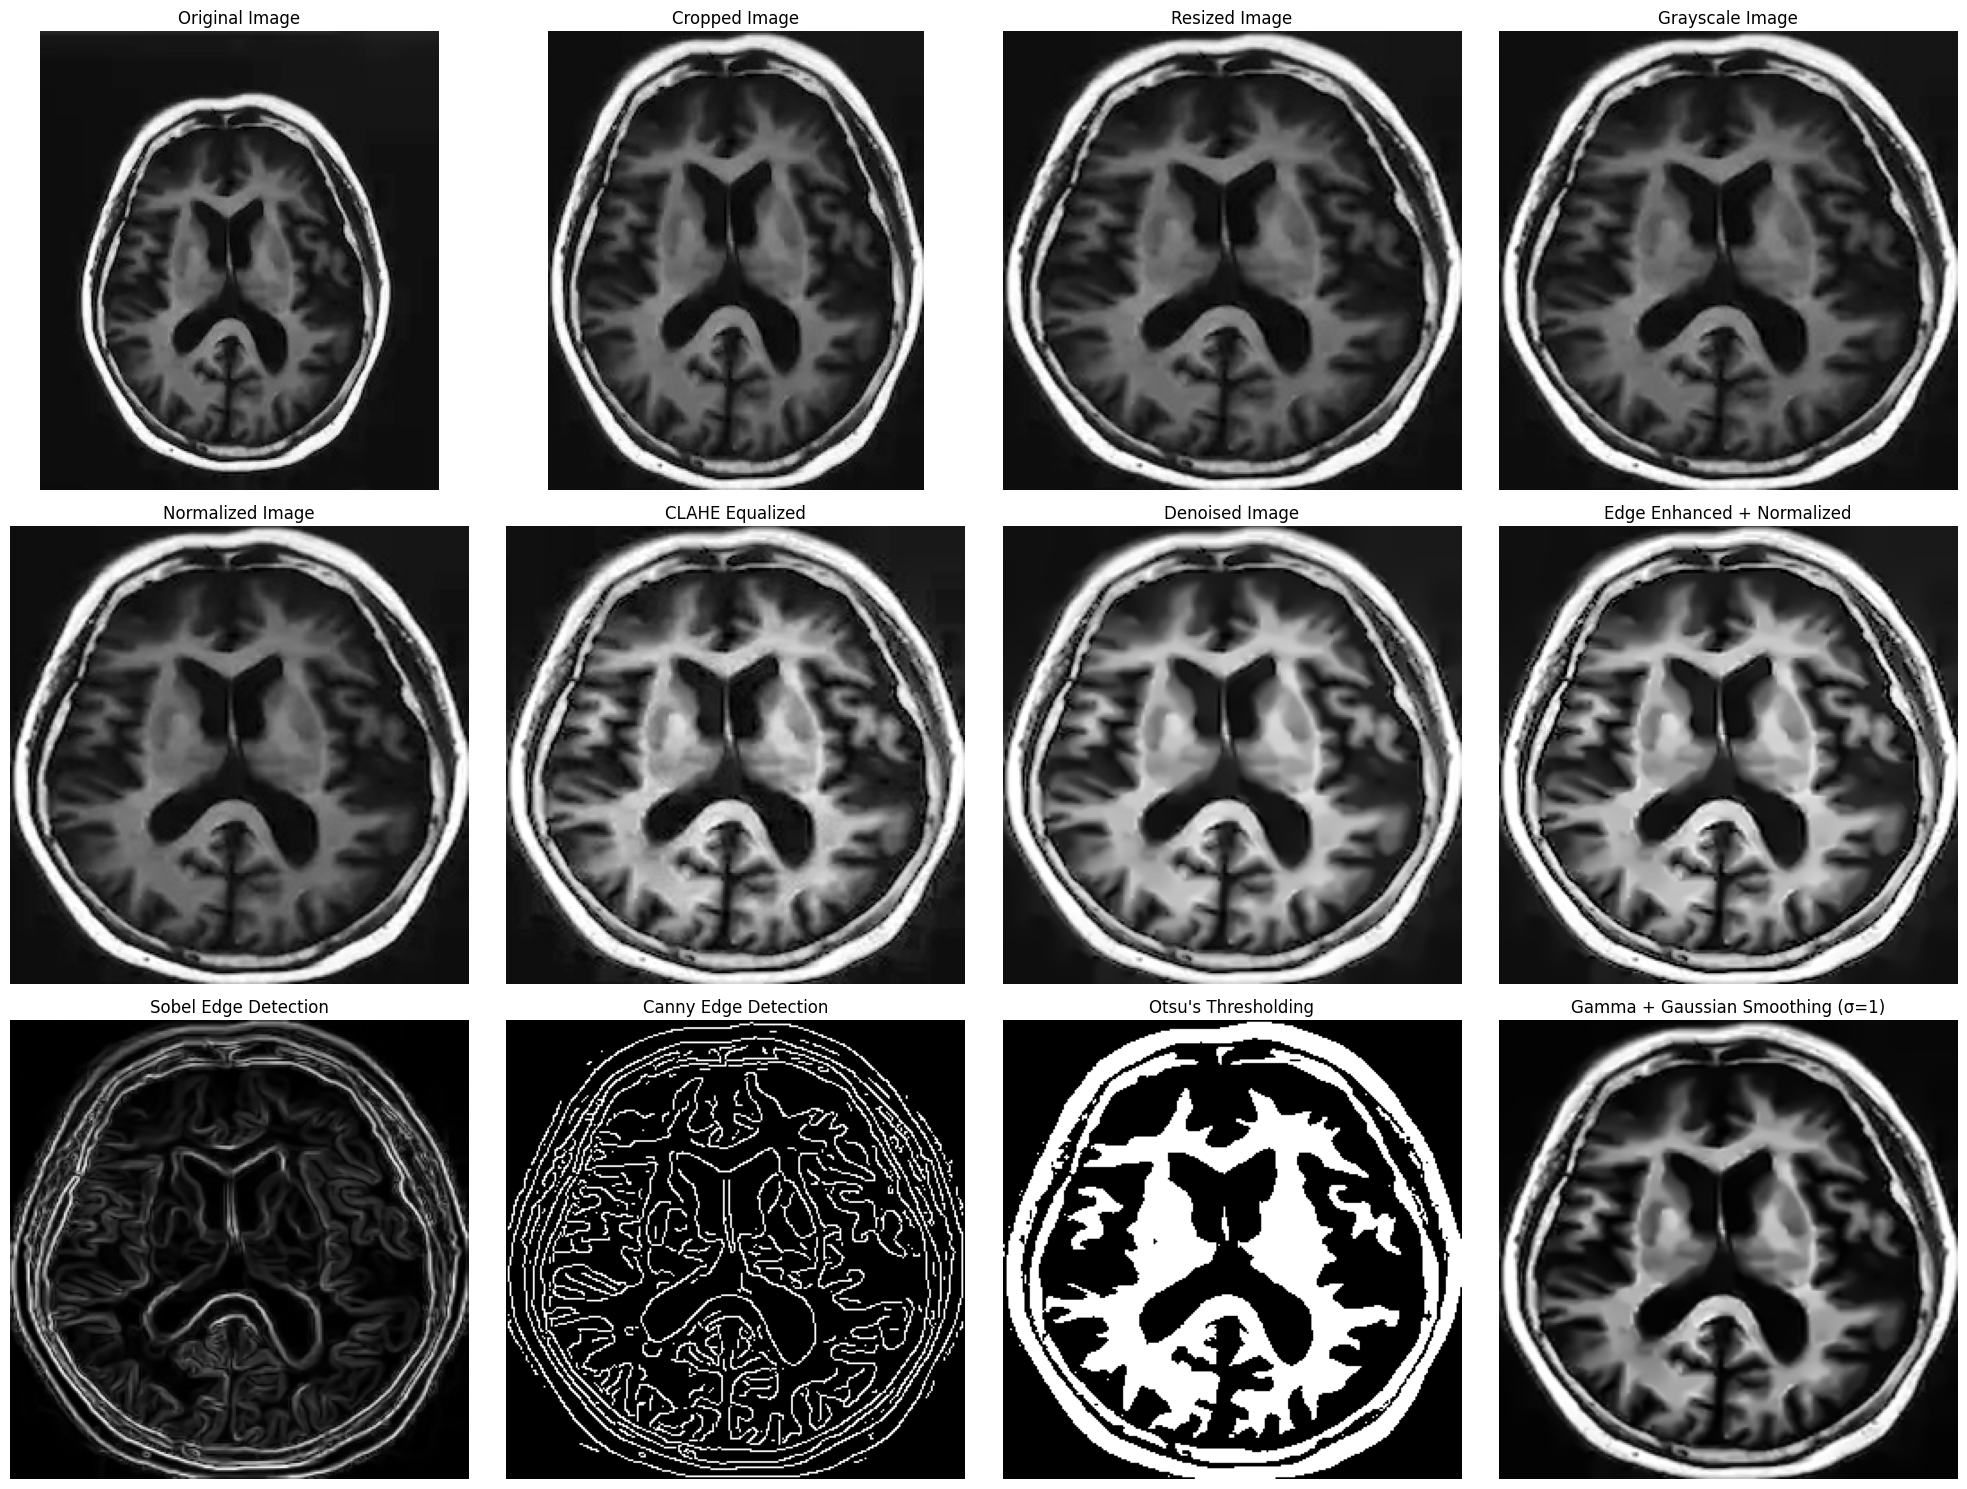

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [4]:
# Load an example brain MRI image
image = cv2.imread('/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0003.jpg')

# Preprocess the image and display intermediate stages
results = preprocess_image(image, show_stages=True)

# Access individual results
edge_enhanced = results["edge_enhanced_normalized"]
gamma_corrected = results["gamma_corrected"]
gamma_gaussian_smoothed = results["gamma_gaussian_smoothed"]

In [12]:
# Function to load and preprocess data
def load_data(data_path, image_size=256):
    """
    Loads and preprocesses images from the given directory.
    Returns images and labels as NumPy arrays.
    """
    images = []
    labels_list = []
    for label in os.listdir(data_path):
        path = os.path.join(data_path, label)
        for file in os.listdir(path):
            # Load the image
            image = cv2.imread(os.path.join(path, file))
            if image is not None:
                # Preprocess the image
                preprocessed_image = preprocess_image(image, image_size=image_size, show_stages=False)
                images.append(preprocessed_image)
                labels_list.append(label)
    # Convert to numpy array and ensure shape is (num_samples, height, width, channels)
    images = np.array(images)
    if images.ndim == 3:
        images = images[..., np.newaxis]  # Add channel dimension
    return images, np.array(labels_list)


In [8]:
# Load and preprocess training and testing data
X_train, Y_train = load_data(train_path, image_size=image_size)
X_test, Y_test = load_data(test_path, image_size=image_size)

In [9]:
# Function to display consistent sample images from each label
def display_sample_images(X, Y, labels, num_samples=5):
    plt.figure(figsize=(12, 12))
    samples_shown = {label: 0 for label in labels}
    total_shown = 0

    for i in range(len(X)):
        label_index = np.argmax(Y[i])
        label = labels[label_index]

        if samples_shown[label] < num_samples:
            plt.subplot(len(labels), num_samples, total_shown + 1)
            plt.imshow(X[i], cmap='gray')
            plt.title(label)
            plt.axis('off')

            samples_shown[label] += 1
            total_shown += 1

        # Stop when we’ve collected enough images
        if total_shown == num_samples * len(labels):
            break

    plt.tight_layout()
    plt.show()

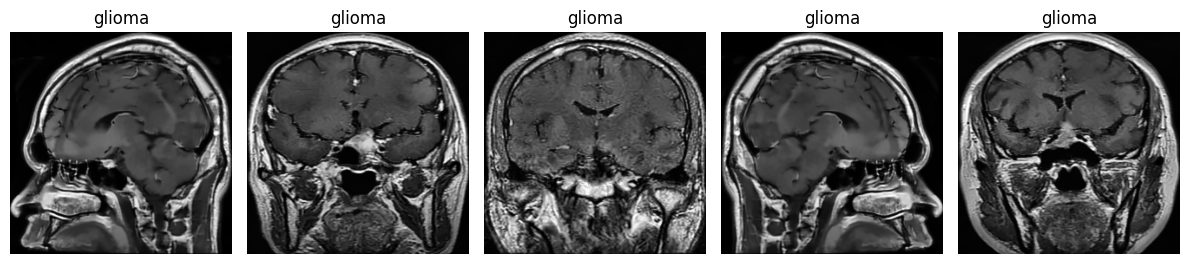

In [10]:
# Display images before training
display_sample_images(X_train, Y_train, labels)

In [11]:

# Shuffle the data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
X_test, Y_test = shuffle(X_test, Y_test, random_state=42)

# Convert labels to numerical values
label_to_index = {label: idx for idx, label in enumerate(np.unique(Y_train))}
Y_train = np.array([label_to_index[label] for label in Y_train])
Y_test = np.array([label_to_index[label] for label in Y_test])

# One-hot encode the labels
num_classes = len(label_to_index)
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes)

In [13]:

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [14]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [15]:
def build_improved_cnn(input_shape=(image_size, image_size, 1)):
    model = models.Sequential()
    
    # Convolutional layers with Batch Normalization and Dropout
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Flatten and dense layers with reduced parameters
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
# Build the improved CNN model
cnn_model = build_improved_cnn(input_shape=(256, 256, 1))

# Model summary
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 8,787,524 (33.52 MB)

 Trainable params: 8,786,308 (33.52 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [17]:
# Train the model
history = cnn_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 44s 199ms/step - accuracy: 0.4547 - loss: 1.4227 - val_accuracy: 0.2133 - val_loss: 2.7805
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.6626 - loss: 0.8610 - val_accuracy: 0.2133 - val_loss: 4.9610
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.7271 - loss: 0.7228 - val_accuracy: 0.2395 - val_loss: 8.3741
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.7545 - loss: 0.6667 - val_accuracy: 0.5262 - val_loss: 1.4451
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.7718 - loss: 0.6320 - val_accuracy: 0.2797 - val_loss: 5.2527
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.7881 - loss: 0.5662 - val_accuracy: 0.4930 - val_loss: 2.6842
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.8016 - loss: 0.5572 - val_accuracy: 0.7937 - val_loss: 0.4823
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.8143 - loss: 0.5002 - val

In [18]:
# Evaluate on test data
test_loss, test_accuracy = cnn_model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5862 - loss: 2.1223
Test Accuracy: 58.73%


In [20]:
# Train the model
history1 = cnn_model.fit(
    X_train, y_train, batch_size=32,
    validation_data=(X_val, y_val),
    epochs=10
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9416 - loss: 0.1784 - val_accuracy: 0.9073 - val_loss: 0.2838
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9666 - loss: 0.1098 - val_accuracy: 0.9493 - val_loss: 0.6845
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9743 - loss: 0.0870 - val_accuracy: 0.9633 - val_loss: 0.1538
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9789 - loss: 0.0670 - val_accuracy: 0.8217 - val_loss: 0.7003
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9787 - loss: 0.0689 - val_accuracy: 0.9423 - val_loss: 0.1752
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9839 - loss: 0.0530 - val_accuracy: 0.8322 - val_loss: 0.6634
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9843 - loss: 0.0484 - val_accuracy: 0.6923 - val_loss: 2.5399
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9849 - loss: 0.0511 - val_acc

In [21]:
# Evaluate on test data
test_loss, test_accuracy = cnn_model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9124 - loss: 0.3261
Test Accuracy: 91.99%


In [22]:
# Train the model
history2 = cnn_model.fit(
    X_train, y_train, batch_size=32,
    validation_data=(X_val, y_val),
    epochs=10
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9884 - loss: 0.0402 - val_accuracy: 0.7395 - val_loss: 1.3604
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9879 - loss: 0.0399 - val_accuracy: 0.9406 - val_loss: 0.2144
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9876 - loss: 0.0385 - val_accuracy: 0.7815 - val_loss: 1.2814
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9895 - loss: 0.0325 - val_accuracy: 0.9598 - val_loss: 0.1523
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9926 - loss: 0.0285 - val_accuracy: 0.9650 - val_loss: 0.1655
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9916 - loss: 0.0220 - val_accuracy: 0.9336 - val_loss: 0.2120
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9884 - loss: 0.0344 - val_accuracy: 0.9388 - val_loss: 0.2284
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9915 - loss: 0.0248 - val_accu

In [23]:
# Evaluate on test data
test_loss, test_accuracy = cnn_model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9650 - loss: 0.1324
Test Accuracy: 96.34%


In [24]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
# Confusion matrix and classification report
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Classification report
    print(classification_report(y_true, y_pred_classes, target_names=labels))
    
    # Additional metrics
    print(f"Accuracy: {accuracy_score(y_true, y_pred_classes):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred_classes, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred_classes, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred_classes, average='weighted'):.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


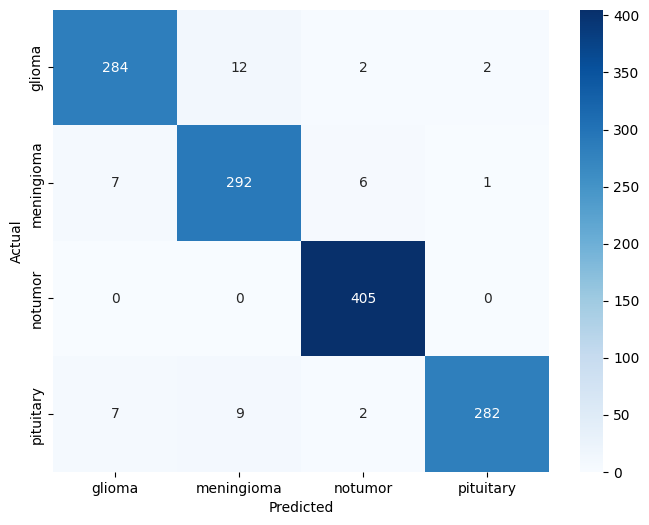

              precision    recall  f1-score   support

      glioma       0.95      0.95      0.95       300
  meningioma       0.93      0.95      0.94       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      0.94      0.96       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311

Accuracy: 0.9634
Precision: 0.9637
Recall: 0.9634
F1 Score: 0.9633


In [25]:

evaluate_model(cnn_model, X_test, Y_test)

In [26]:
# Plot training and validation accuracy/loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()


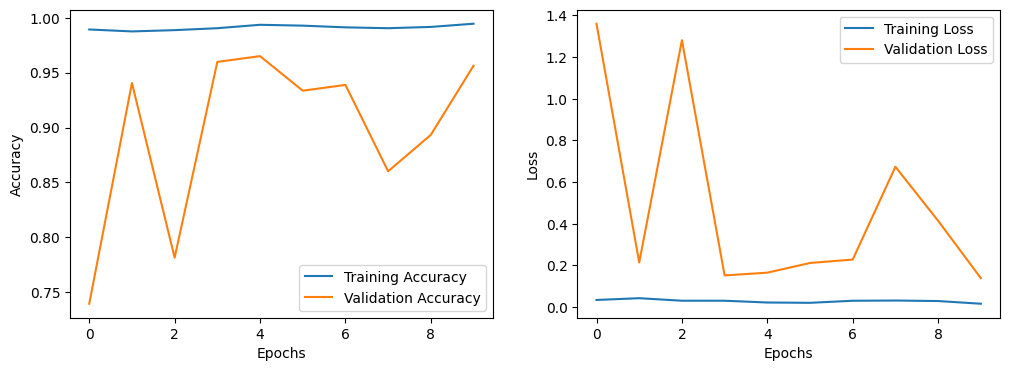

In [28]:
plot_training_history(history2)

In [31]:
def predict_image(model, image_path):
    """
    Predicts the class of a brain MRI image using the trained model.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load image.")
        return

    # Preprocess the image and show stages
    processed_image = preprocess_image(image, show_stages=True)
    
    # Reshape the image for model prediction
    processed_image = processed_image.reshape(1, image_size, image_size, 1)
    
    # Make prediction
    prediction = model.predict(processed_image)
    predicted_class = labels[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    # Display the final preprocessed image
    plt.figure(figsize=(6, 6))
    plt.imshow(processed_image[0, :, :, 0], cmap='gray')
    plt.title(f'Final Preprocessed Image\nPredicted: {predicted_class}, Confidence: {confidence * 100:.2f}%')
    plt.axis('off')
    plt.show()
    
    print(f"Predicted Class: {predicted_class}, Confidence: {confidence * 100:.2f}%")

In [ ]:
# Example prediction
predict_image(cnn_model, '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0006.jpg')

In [ ]:
cnn_modal.save('tumor7.h5')